In [1]:
# pip install scikit-learn

In [1]:
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import keras.utils as image
from keras.models import Sequential
from keras import models
from keras.layers import Input, Resizing, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from tensorflow.keras.optimizers import Adam

from keras import regularizers
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [64]:
train_dir = 'dataset_transport\\train'
test_dir = 'dataset_transport\\test'

# data preprocessing

In [65]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
batch_size = 32

In [66]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,             # Increase rotation to 15° for more variety
    width_shift_range=0.1,         # Increase translation to 10% width
    height_shift_range=0.1,        # Increase translation to 10% height
    horizontal_flip=True,          # Keep flipping enabled
    shear_range=0.1,               # Adds perspective distortion (useful for small images)
    fill_mode='nearest'            # Avoids creating black pixels when shifting
)

validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 6000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


Equal number of images per class

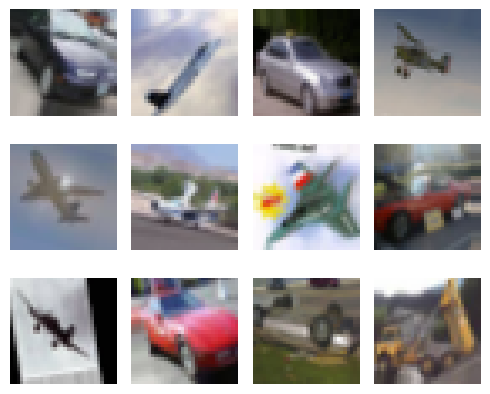

In [67]:
#view some images
import PIL.Image as Image
images,labels = next(train_data_gen)  #it retrieves the next batch of data
def plotImages(images, labels):
  fig, axes = plt.subplots(3, 4, figsize=(5,5))
  axes = axes.flatten()

  for img, label, ax in zip( images, labels, axes):
    ax.imshow(img)
    label = np.argmax(label)
    label = 'airplane' if label == 0 else ('automobile' if label == 1 else 'truck')
    ax.axis('off')
    plt.tight_layout()
  plt.show()

plotImages(images[:12],labels[:12])

# CNN Model

In [ ]:
T2_221128Z_model = models.Sequential()
# Block 1
T2_221128Z_model.add(Conv2D(32, 3, padding='same', kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(32, 32, 3)))
T2_221128Z_model.add(BatchNormalization())
T2_221128Z_model.add(MaxPooling2D())

# Block 2
T2_221128Z_model.add(Conv2D(64, 3, padding='same', activation='relu'))
T2_221128Z_model.add(BatchNormalization())
T2_221128Z_model.add(MaxPooling2D())

# Block 3
T2_221128Z_model.add(Conv2D(128, 3, padding='same', activation='relu'))
T2_221128Z_model.add(BatchNormalization())
T2_221128Z_model.add(MaxPooling2D())

#Block 4
T2_221128Z_model.add(Conv2D(256, 3, padding='same', activation='relu'))
T2_221128Z_model.add(BatchNormalization())
T2_221128Z_model.add(MaxPooling2D())

# Fully Connected Layers
T2_221128Z_model.add(Flatten())
T2_221128Z_model.add(Dense(128, activation='relu'))
T2_221128Z_model.add(Dropout(0.4))
T2_221128Z_model.add(Dense(3, activation='softmax'))  # Categorical classification

T2_221128Z_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_111 (Ba  (None, 32, 32, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_111 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_112 (Ba  (None, 16, 16, 64)       256       
 tchNormalization)                                               
                                                      

In [69]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

T2_221128Z_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])  #categorical classification
history = T2_221128Z_model.fit(train_data_gen,epochs=50, validation_data=validation_data_gen, callbacks= es_callback)

Epoch 1/50
188/188 [==============================] - 5s 26ms/step - loss: 0.9557 - accuracy: 0.5710 - val_loss: 3.1397 - val_accuracy: 0.3333
Epoch 2/50
188/188 [==============================] - 5s 25ms/step - loss: 0.7849 - accuracy: 0.6478 - val_loss: 2.3557 - val_accuracy: 0.3660
Epoch 3/50
188/188 [==============================] - 5s 25ms/step - loss: 0.7139 - accuracy: 0.6788 - val_loss: 0.6408 - val_accuracy: 0.7373
Epoch 4/50
188/188 [==============================] - 5s 25ms/step - loss: 0.6694 - accuracy: 0.7130 - val_loss: 0.5471 - val_accuracy: 0.7760
Epoch 5/50
188/188 [==============================] - 5s 25ms/step - loss: 0.6457 - accuracy: 0.7288 - val_loss: 0.5242 - val_accuracy: 0.7867
Epoch 6/50
188/188 [==============================] - 5s 25ms/step - loss: 0.6197 - accuracy: 0.7402 - val_loss: 0.5219 - val_accuracy: 0.7860
Epoch 7/50
188/188 [==============================] - 5s 25ms/step - loss: 0.5787 - accuracy: 0.7637 - val_loss: 0.4664 - val_accuracy: 0.8220

In [70]:
# Generate predictions
predicted_probabilities = T2_221128Z_model.predict(validation_data_gen, steps=validation_data_gen.samples // validation_data_gen.batch_size + 1)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Extract true labels
true_labels = validation_data_gen.classes

# Ensure predictions and true labels match in size
CNN_predicted_labels = predicted_labels[:len(true_labels)]  # Trim if necessary

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, CNN_predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Generate the classification report
class_names = list(validation_data_gen.class_indices.keys())  # Extract class names
report = classification_report(true_labels, CNN_predicted_labels, target_names=class_names)
print(report)

47/47 [==============================] - 1s 10ms/step
Confusion Matrix:
 [[451  19  30]
 [ 12 449  39]
 [ 31  45 424]]
              precision    recall  f1-score   support

    airplane       0.91      0.90      0.91       500
  automobile       0.88      0.90      0.89       500
       truck       0.86      0.85      0.85       500

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



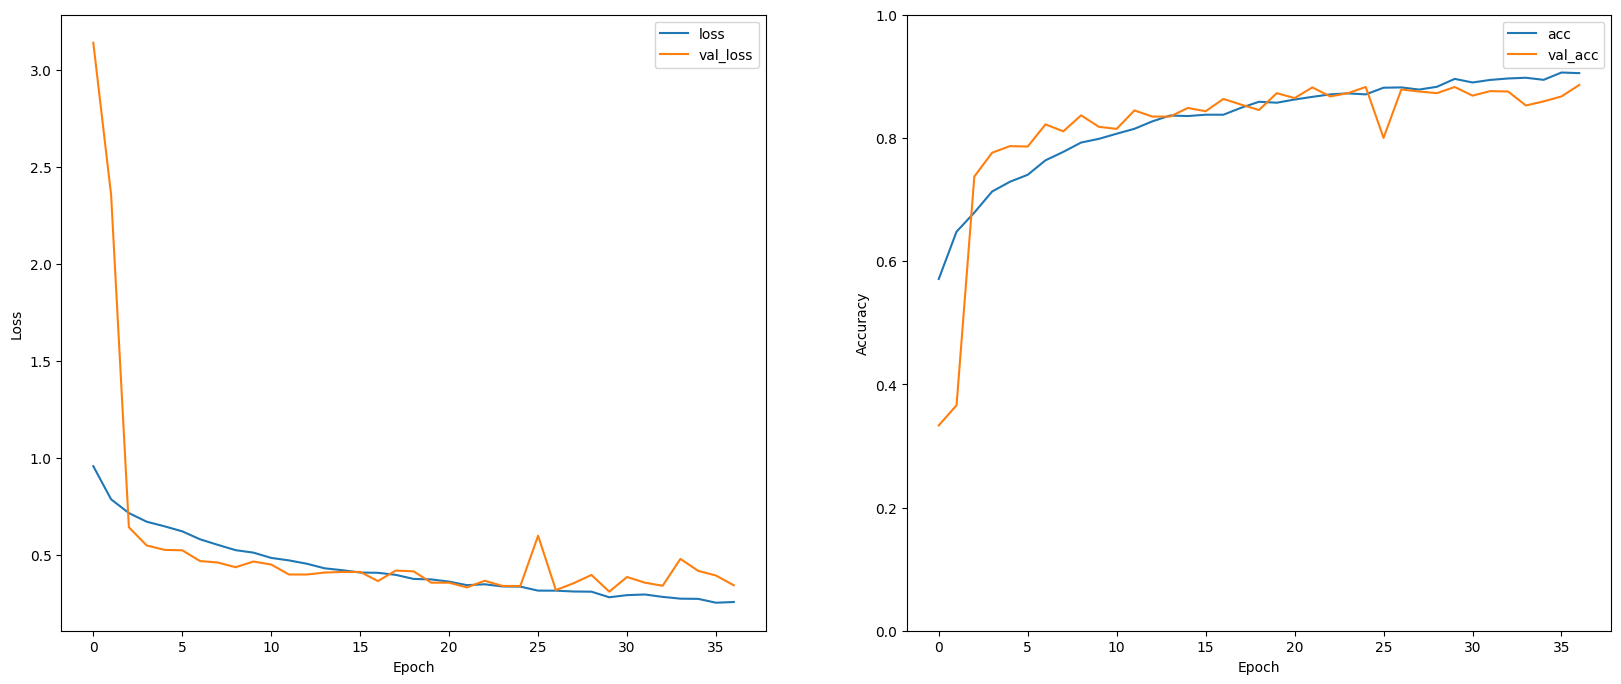

In [71]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(loss,label='loss')
plt.plot(val_loss,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc,label='acc')
plt.plot(val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])

plt.show()

In [72]:
save_CNN_path = T2_221128Z_model.save("221128Z_CNN_model_checkpoint_full.h5")

In [73]:
import numpy as np
from PIL import Image

# class_indices = train_data_gen.class_indices  # Get class index dictionary
# class_labels = {v: k for k, v in class_indices.items()}  # Reverse to get index-to-label mapping

# print(f"Class Labels: {class_labels}")  # Prints class mapping
idx_to_class = {0: 'airplane', 1: 'automobile', 2: 'truck'}

def classify_CNN_image(image_path, model, idx_to_class, img_size=(32, 32)):
    # 1) Load the image with PIL
    img = Image.open(image_path).convert('RGB')

    # 2) Resize to match the model’s expected input size (299x299)
    img = img.resize(img_size, Image.Resampling.LANCZOS)

    # 3) Convert image to NumPy array
    img_array = np.array(img).astype('float32')

    # 4) Normalize pixel values from [0, 255] to [0, 1] (if model was trained with normalization)
    img_array /= 255.0

    # 5) Expand dimensions to match model’s expected shape (1, 32, 32, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # 6) Make prediction
    predictions = model.predict(img_array)

    # 7) Extract the predicted class and confidence score
    pred_idx = np.argmax(predictions, axis=1)[0]
    confidence = float(np.max(predictions))

    predicted_class = idx_to_class[pred_idx]
    return predicted_class, confidence


In [74]:
CNN_model_path = r"C:\Users\jinbi\OneDrive\Documents\ADL\project\221128Z_CNN_model_checkpoint_full.h5"
CNN_model = keras.models.load_model(CNN_model_path)

print("Model loaded successfully.")

Model loaded successfully.


In [75]:
 # Path to the test image
image_path = r"C:\Users\jinbi\OneDrive\Documents\ADL\project\Online_Data\automobile3.jpg"

# Run classification
predicted_class, confidence = classify_CNN_image(image_path, CNN_model, idx_to_class)

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

1/1 [==============================] - 0s 77ms/step
Predicted Class: automobile, Confidence: 0.9745


In [76]:
 # Path to the test image
image_path = r"C:\Users\jinbi\OneDrive\Documents\ADL\project\Online_Data\Plane1.jpg"

# Run classification
predicted_class, confidence = classify_CNN_image(image_path, CNN_model, idx_to_class)

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

1/1 [==============================] - 0s 15ms/step
Predicted Class: airplane, Confidence: 0.9999


In [77]:
 # Path to the test image
image_path = r"C:\Users\jinbi\OneDrive\Documents\ADL\project\Online_Data\truck1.jpg"

# Run classification
predicted_class, confidence = classify_CNN_image(image_path, CNN_model, idx_to_class)

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

1/1 [==============================] - 0s 16ms/step
Predicted Class: truck, Confidence: 0.9281


# Summary of CNN model:

Since the training images are 32x32. To enhance generalization, I applied data augmentation, including rotations, width/height shifts, shear, and horizontal flips. Vertical flips were excluded as it is unrealistic for airplanes, automobiles, and trucks to be upside down. I kept the augmentations minimal because the images were low-resolution, and drastic changes could distort important features. The model architecture consists of four convolutional layers (32, 64, 128, 256 filters) with ReLU activation, Batch Normalisation and max-pooling, followed by a Flatten layer and dense layers. To prevent overfitting, I used L2 regularization (0.001), dropout (40%), and early stopping. The final classification layer uses softmax activation for multi-class classification. The model's performance was evaluated using accuracy and validation loss. I trained the model with 50 epochs but was stopped at epoch 36 due to early stopping to ensure convergence without overfitting. The final accuracy/validation accuracy is 90.52%/88.60%.

# Transfer learning

In [17]:
train_dir = 'dataset_transport\\train'
test_dir = 'dataset_transport\\test'

IMG_HEIGHT = 224 #image sized for DenseNet121 and MobileNetV2
IMG_WIDTH = 224 
batch_size = 32

train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,           # Increase rotation to 10° for better orientation robustness
    width_shift_range=0.1,       # Increase translation to 10% width
    height_shift_range=0.1,      # Increase translation to 10% height
    horizontal_flip=True,        # Helps with left-right variations
    zoom_range=0.1,             # Slightly increase zoom range for scale variance
    fill_mode='nearest'          # Avoids black pixels when shifting
)


validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 6000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


## MobileNetV2

In [18]:
from keras.layers import GlobalAveragePooling2D
from keras.applications.mobilenet_v2 import MobileNetV2

#MobileNetV2 is lightweight and allows for efficient processing with low computational power requirements while still maintaining high accuracy. 
MN_base_model=MobileNetV2(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

x = MN_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
preds=Dense(3, activation='softmax')(x)

T2_221128Z_TL_MN_model= Model(inputs=MN_base_model.input, outputs=preds)
T2_221128Z_TL_MN_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [19]:
#To freeze the base model layers
MN_base_model.trainable = False
for layer in MN_base_model.layers:
    print(layer.name, layer.trainable)

T2_221128Z_TL_MN_model.summary()

input_1 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_depthwi

In [20]:
TL_MN_es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

T2_221128Z_TL_MN_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
TL_MN_History = T2_221128Z_TL_MN_model.fit(train_data_gen, epochs=25, validation_data=validation_data_gen, callbacks= TL_MN_es_callback)

Epoch 1/25
188/188 [==============================] - 34s 174ms/step - loss: 0.7251 - accuracy: 0.7112 - val_loss: 0.4973 - val_accuracy: 0.7887
Epoch 2/25
188/188 [==============================] - 32s 171ms/step - loss: 0.4855 - accuracy: 0.8185 - val_loss: 0.4289 - val_accuracy: 0.8367
Epoch 3/25
188/188 [==============================] - 33s 174ms/step - loss: 0.4345 - accuracy: 0.8318 - val_loss: 0.3997 - val_accuracy: 0.8433
Epoch 4/25
188/188 [==============================] - 33s 175ms/step - loss: 0.4084 - accuracy: 0.8435 - val_loss: 0.3760 - val_accuracy: 0.8487
Epoch 5/25
188/188 [==============================] - 32s 172ms/step - loss: 0.3819 - accuracy: 0.8555 - val_loss: 0.3934 - val_accuracy: 0.8393
Epoch 6/25
188/188 [==============================] - 32s 171ms/step - loss: 0.3706 - accuracy: 0.8592 - val_loss: 0.3930 - val_accuracy: 0.8493
Epoch 7/25
188/188 [==============================] - 33s 175ms/step - loss: 0.3583 - accuracy: 0.8602 - val_loss: 0.3560 - val_ac

In [21]:
# Generate predictions
TL_MN_predicted_probabilities = T2_221128Z_TL_MN_model.predict(validation_data_gen, steps=validation_data_gen.samples // validation_data_gen.batch_size + 1)
TL_MN_predicted_labels = np.argmax(TL_MN_predicted_probabilities, axis=1)

# Extract true labels
true_labels = validation_data_gen.classes

# Ensure predictions and true labels match in size
T2_221128Z_TL_MN_predicted_labels = TL_MN_predicted_labels[:len(true_labels)]

# Generate the classification report
class_names = list(validation_data_gen.class_indices.keys())  # Extract class names
report = classification_report(true_labels, T2_221128Z_TL_MN_predicted_labels, target_names=class_names)
print(report)

47/47 [==============================] - 2s 40ms/step
              precision    recall  f1-score   support

    airplane       0.94      0.85      0.90       500
  automobile       0.82      0.92      0.87       500
       truck       0.88      0.86      0.87       500

    accuracy                           0.88      1500
   macro avg       0.88      0.88      0.88      1500
weighted avg       0.88      0.88      0.88      1500



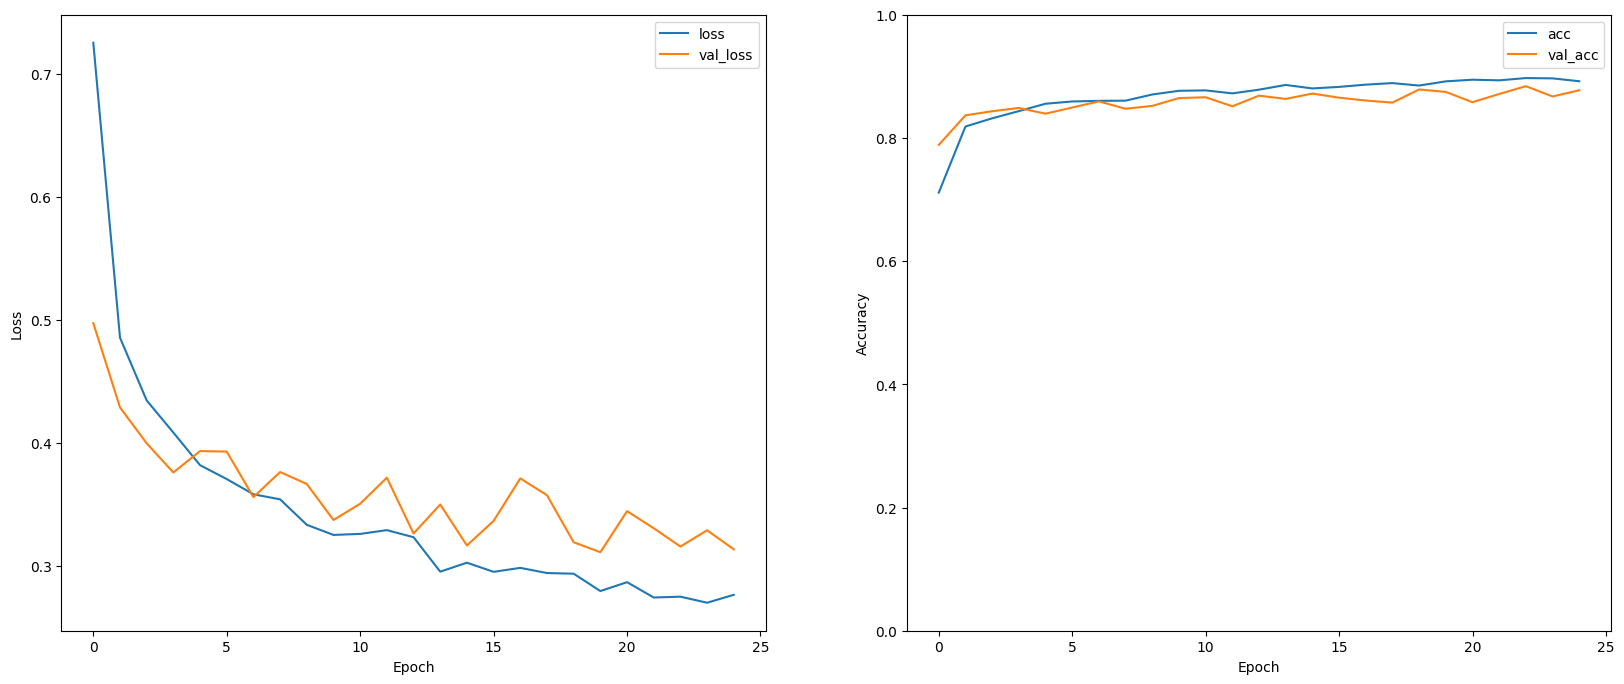

In [22]:
T2_221128Z_TL_MN_loss = TL_MN_History.history['loss']
T2_221128Z_TL_MN_val_loss = TL_MN_History.history['val_loss']
T2_221128Z_TL_MN_acc = TL_MN_History.history['accuracy']
T2_221128Z_TL_MN_val_acc = TL_MN_History.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(T2_221128Z_TL_MN_loss,label='loss')
plt.plot(T2_221128Z_TL_MN_val_loss ,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T2_221128Z_TL_MN_acc,label='acc')
plt.plot(T2_221128Z_TL_MN_val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])

plt.show()

## DenseNet121

In [23]:
from keras.layers import GlobalAveragePooling2D
from keras.applications.densenet import DenseNet121
DN_base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x1 = DN_base_model.output
x1=GlobalAveragePooling2D()(x1)
x1 = Dense(256, activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.3)(x1)

DN_preds = Dense(3, activation='softmax')(x1)

T2_221128Z_TL_DN_model= Model(inputs=DN_base_model.input, outputs=DN_preds)
T2_221128Z_TL_DN_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [24]:
DN_base_model.trainable = False

TL_DN_es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

T2_221128Z_TL_DN_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
TL_DN_History = T2_221128Z_TL_DN_model.fit(train_data_gen, epochs=25, validation_data=validation_data_gen, callbacks= TL_DN_es_callback)

Epoch 1/25
188/188 [==============================] - 42s 205ms/step - loss: 0.8354 - accuracy: 0.6600 - val_loss: 0.5592 - val_accuracy: 0.7767
Epoch 2/25
188/188 [==============================] - 38s 199ms/step - loss: 0.5383 - accuracy: 0.7825 - val_loss: 0.4404 - val_accuracy: 0.8127
Epoch 3/25
188/188 [==============================] - 38s 200ms/step - loss: 0.4795 - accuracy: 0.8090 - val_loss: 0.3817 - val_accuracy: 0.8493
Epoch 4/25
188/188 [==============================] - 38s 202ms/step - loss: 0.4335 - accuracy: 0.8270 - val_loss: 0.3598 - val_accuracy: 0.8607
Epoch 5/25
188/188 [==============================] - 38s 203ms/step - loss: 0.4055 - accuracy: 0.8365 - val_loss: 0.3712 - val_accuracy: 0.8493
Epoch 6/25
188/188 [==============================] - 38s 202ms/step - loss: 0.3945 - accuracy: 0.8488 - val_loss: 0.3348 - val_accuracy: 0.8727
Epoch 7/25
188/188 [==============================] - 39s 205ms/step - loss: 0.3835 - accuracy: 0.8468 - val_loss: 0.3229 - val_ac

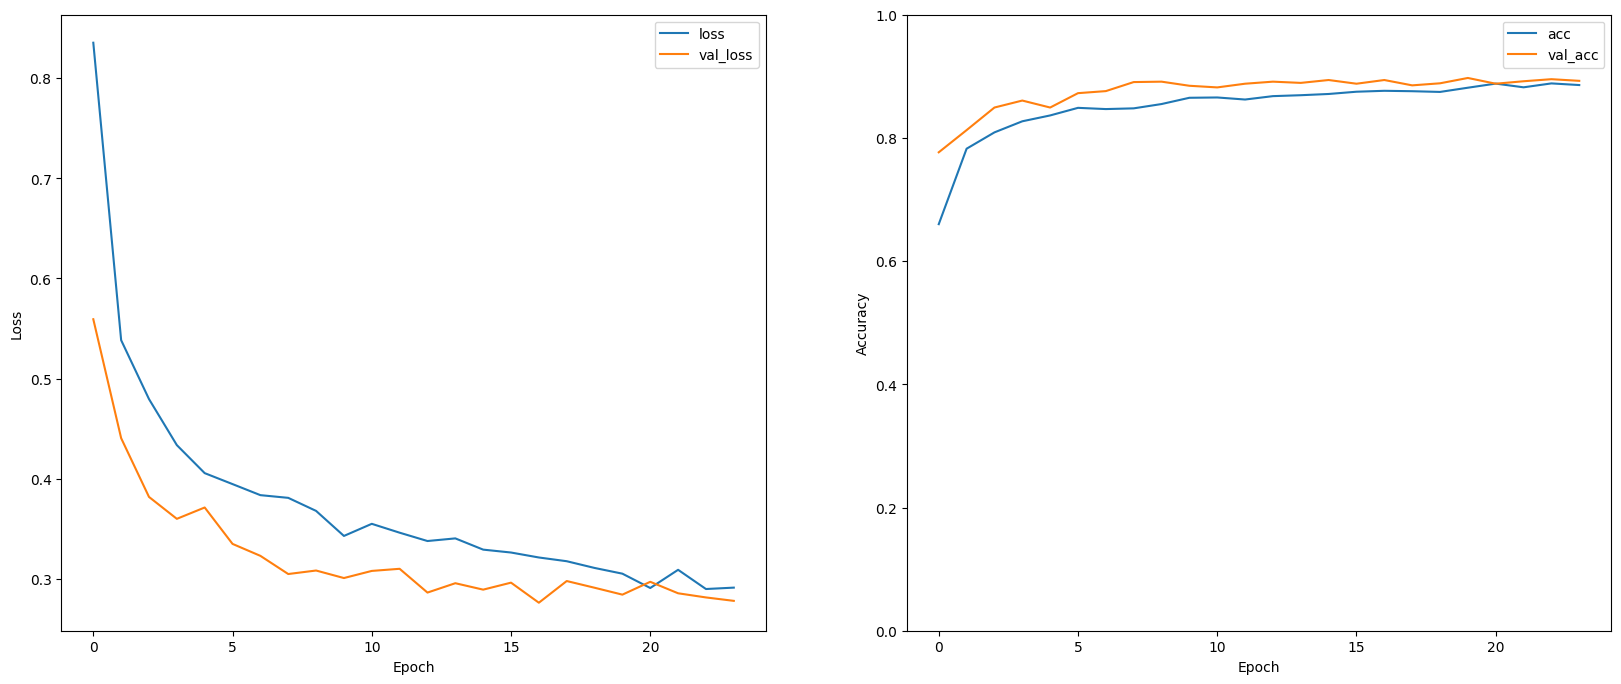

In [25]:
T2_221128Z_TL_DN_loss = TL_DN_History.history['loss']
T2_221128Z_TL_DN_val_loss = TL_DN_History.history['val_loss']
T2_221128Z_TL_DN_acc = TL_DN_History.history['accuracy']
T2_221128Z_TL_DN_val_acc = TL_DN_History.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(T2_221128Z_TL_DN_loss,label='loss')
plt.plot(T2_221128Z_TL_DN_val_loss ,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T2_221128Z_TL_DN_acc,label='acc')
plt.plot(T2_221128Z_TL_DN_val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])

plt.show()

## InceptionV3

In [26]:
train_dir = 'dataset_transport\\train'
test_dir = 'dataset_transport\\test'

IMG_HEIGHT = 299 #image sized for InceptionV3
IMG_WIDTH = 299 
batch_size = 32

train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,           
    width_shift_range=0.1,      
    height_shift_range=0.1,     
    horizontal_flip=True,     
    zoom_range=0.1,        
    fill_mode='nearest'          
)


validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 6000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [27]:
from keras.applications.inception_v3 import InceptionV3

IN_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x2 = IN_base_model.output
x2=GlobalAveragePooling2D()(x2)
x2 = Dense(256, activation='relu')(x2)
x2 = BatchNormalization()(x2)  # Normalization for stability
x2 = Dropout(0.3)(x2)
IN_preds=Dense(3, activation='softmax')(x2)

T2_221128Z_TL_IN_model= Model(inputs=IN_base_model.input, outputs=IN_preds)
T2_221128Z_TL_IN_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 149, 149, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                                                           

In [28]:
IN_base_model.trainable = False
TL_IN_es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)

T2_221128Z_TL_IN_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
TL_IN_History = T2_221128Z_TL_IN_model.fit(train_data_gen, epochs=25, validation_data=validation_data_gen, callbacks= TL_IN_es_callback)

Epoch 1/25
188/188 [==============================] - 70s 353ms/step - loss: 0.6389 - accuracy: 0.7448 - val_loss: 0.3429 - val_accuracy: 0.8673
Epoch 2/25
188/188 [==============================] - 66s 350ms/step - loss: 0.4165 - accuracy: 0.8355 - val_loss: 0.2486 - val_accuracy: 0.9127
Epoch 3/25
188/188 [==============================] - 66s 348ms/step - loss: 0.3926 - accuracy: 0.8460 - val_loss: 0.2378 - val_accuracy: 0.9147
Epoch 4/25
188/188 [==============================] - 65s 347ms/step - loss: 0.3657 - accuracy: 0.8598 - val_loss: 0.2220 - val_accuracy: 0.9200
Epoch 5/25
188/188 [==============================] - 65s 345ms/step - loss: 0.3455 - accuracy: 0.8647 - val_loss: 0.2383 - val_accuracy: 0.9153
Epoch 6/25
188/188 [==============================] - 66s 350ms/step - loss: 0.3328 - accuracy: 0.8703 - val_loss: 0.2352 - val_accuracy: 0.9187
Epoch 7/25
188/188 [==============================] - 66s 352ms/step - loss: 0.3190 - accuracy: 0.8740 - val_loss: 0.2091 - val_ac

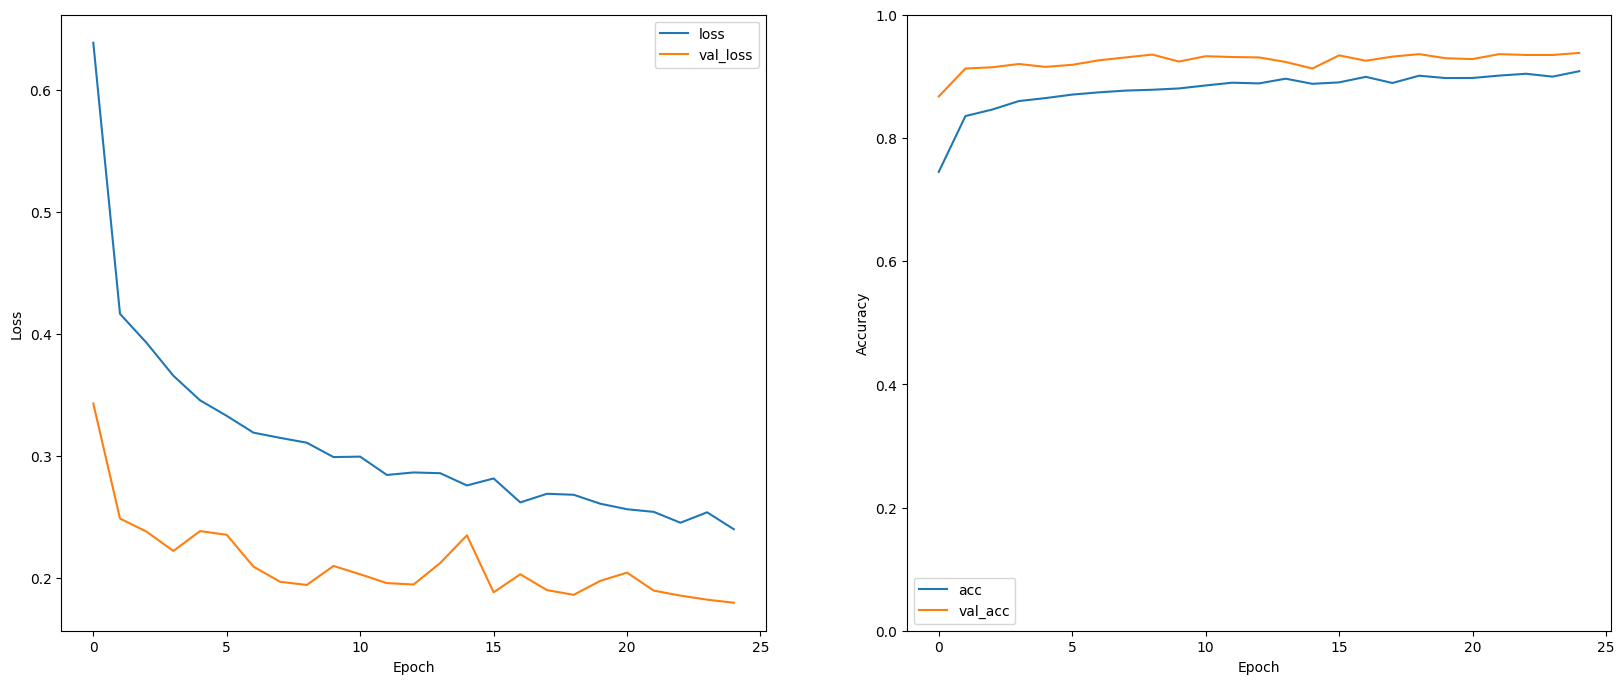

In [29]:
T2_221128Z_TL_IN_loss = TL_IN_History.history['loss']
T2_221128Z_TL_IN_val_loss = TL_IN_History.history['val_loss']
T2_221128Z_TL_IN_acc = TL_IN_History.history['accuracy']
T2_221128Z_TL_IN_val_acc = TL_IN_History.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(T2_221128Z_TL_IN_loss,label='loss')
plt.plot(T2_221128Z_TL_IN_val_loss ,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T2_221128Z_TL_IN_acc,label='acc')
plt.plot(T2_221128Z_TL_IN_val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])

plt.show()

MobileNetV2 Accuracy is the lowest.
Loss graph is unstable and not converging, indicating inconsistency.
Not worth fine-tuning.

InceptionV3: Highest accuracy but underfitting. worth fine tuning by unfreezing layers.

DenseNet121: More stable, but slightly lower accuracy. worth fine tuning and training longer (tried but accuracy Plateau at 90%)

Therefore InceptionV3 is the most suitble candidate for further firn tuning to improve the model's performance.

## Chosen model training (InceptionV3)

In [3]:
train_dir = 'dataset_transport\\train'
test_dir = 'dataset_transport\\test'

IMG_HEIGHT = 299 #image sized for InceptionV3
IMG_WIDTH = 299
batch_size = 32

train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,          
    brightness_range=[0.9,1.1],
    horizontal_flip=True,
    fill_mode='nearest'      # fill missing pixels after shifts
)

validation_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

validation_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')

Found 6000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [4]:
from keras.applications.inception_v3 import InceptionV3
T2_221128Z_TL_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x_final = T2_221128Z_TL_base_model.output
x_final =GlobalAveragePooling2D()(x_final)

x_final = Dense(256, activation='relu')(x_final)
x_final = BatchNormalization()(x_final)
x_final = Dropout(0.3)(x_final)

TL_preds = Dense(3, activation='softmax')(x_final)

T2_221128Z_TL_model= Model(inputs=T2_221128Z_TL_base_model.input, outputs=TL_preds)
T2_221128Z_TL_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [5]:
T2_221128Z_TL_base_model.trainable = False
T2_221128Z_TL_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

T2_221128Z_TL_model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
TL_History = T2_221128Z_TL_model.fit(train_data_gen, epochs=30, validation_data=validation_data_gen, callbacks=[early_stopping])

Epoch 1/30
188/188 [==============================] - 90s 430ms/step - loss: 0.5608 - accuracy: 0.7760 - val_loss: 0.2470 - val_accuracy: 0.9133
Epoch 2/30
188/188 [==============================] - 76s 405ms/step - loss: 0.4542 - accuracy: 0.8192 - val_loss: 0.2281 - val_accuracy: 0.9160
Epoch 3/30
188/188 [==============================] - 76s 406ms/step - loss: 0.4184 - accuracy: 0.8345 - val_loss: 0.2878 - val_accuracy: 0.8933
Epoch 4/30
188/188 [==============================] - 77s 408ms/step - loss: 0.3972 - accuracy: 0.8407 - val_loss: 0.2305 - val_accuracy: 0.9173
Epoch 5/30
188/188 [==============================] - 77s 409ms/step - loss: 0.3735 - accuracy: 0.8542 - val_loss: 0.2402 - val_accuracy: 0.9147
Epoch 6/30
188/188 [==============================] - 77s 407ms/step - loss: 0.3757 - accuracy: 0.8498 - val_loss: 0.2132 - val_accuracy: 0.9253
Epoch 7/30
188/188 [==============================] - 77s 411ms/step - loss: 0.3616 - accuracy: 0.8613 - val_loss: 0.2388 - val_ac

In [7]:
# Unfreeze Last 50 Layers
for layer in T2_221128Z_TL_base_model.layers[-50:]:
    layer.trainable = True

# Lower Learning Rate for Fine-Tuning
T2_221128Z_TL_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue Training with Fine-Tuning
TL_FineTune_History = T2_221128Z_TL_model.fit(train_data_gen, epochs=30, validation_data=validation_data_gen, callbacks=[early_stopping])

Epoch 1/30
188/188 [==============================] - 164s 828ms/step - loss: 0.4102 - accuracy: 0.8370 - val_loss: 0.2178 - val_accuracy: 0.9247
Epoch 2/30
188/188 [==============================] - 112s 589ms/step - loss: 0.3243 - accuracy: 0.8742 - val_loss: 0.2002 - val_accuracy: 0.9313
Epoch 3/30
188/188 [==============================] - 79s 420ms/step - loss: 0.3185 - accuracy: 0.8782 - val_loss: 0.1971 - val_accuracy: 0.9327
Epoch 4/30
188/188 [==============================] - 140s 748ms/step - loss: 0.2940 - accuracy: 0.8880 - val_loss: 0.1886 - val_accuracy: 0.9353
Epoch 5/30
188/188 [==============================] - 78s 417ms/step - loss: 0.2708 - accuracy: 0.8938 - val_loss: 0.1764 - val_accuracy: 0.9393
Epoch 6/30
188/188 [==============================] - 139s 743ms/step - loss: 0.2680 - accuracy: 0.8958 - val_loss: 0.1697 - val_accuracy: 0.9393
Epoch 7/30
188/188 [==============================] - 154s 817ms/step - loss: 0.2723 - accuracy: 0.8970 - val_loss: 0.1745 - v

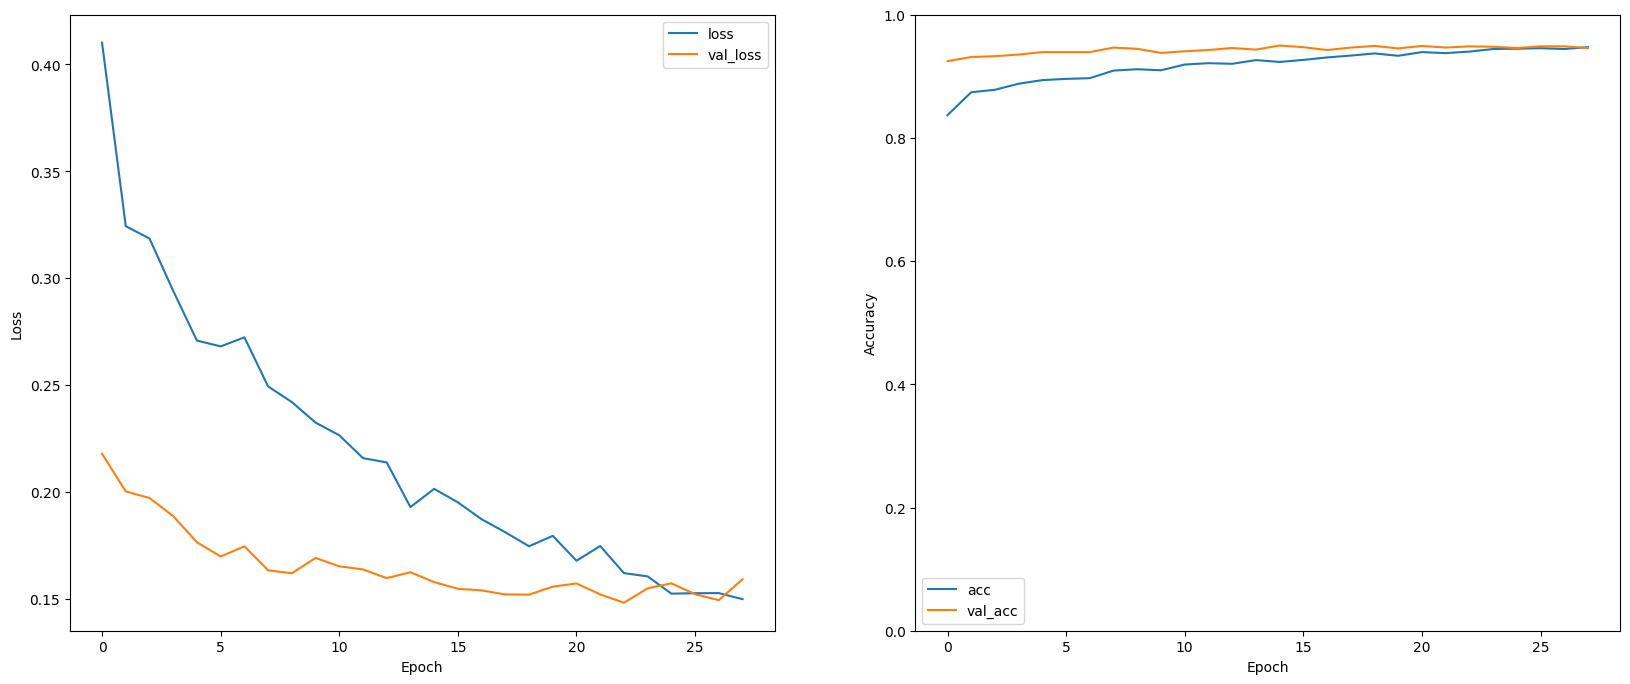

In [8]:
T2_221128Z_TL_model_loss = TL_FineTune_History.history['loss']
T2_221128Z_TL_model_val_loss = TL_FineTune_History.history['val_loss']
T2_221128Z_TL_model_acc = TL_FineTune_History.history['accuracy']
T2_221128Z_TL_model_val_acc = TL_FineTune_History.history['val_accuracy']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(T2_221128Z_TL_model_loss,label='loss')
plt.plot(T2_221128Z_TL_model_val_loss ,label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T2_221128Z_TL_model_acc,label='acc')
plt.plot(T2_221128Z_TL_model_val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0, 1])

plt.show()

In [11]:
# Generate predictions
predicted_probabilities = T2_221128Z_TL_model.predict(validation_data_gen, steps=validation_data_gen.samples // validation_data_gen.batch_size + 1)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Extract true labels
true_labels = validation_data_gen.classes

# Ensure predictions and true labels match in size
CNN_predicted_labels = predicted_labels[:len(true_labels)]  # Trim if necessary

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, CNN_predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Generate the classification report
class_names = list(validation_data_gen.class_indices.keys())  # Extract class names
report = classification_report(true_labels, CNN_predicted_labels, target_names=class_names)
print(report)

47/47 [==============================] - 8s 172ms/step
Confusion Matrix:
 [[487   4   9]
 [  5 474  21]
 [ 13  25 462]]
              precision    recall  f1-score   support

    airplane       0.96      0.97      0.97       500
  automobile       0.94      0.95      0.95       500
       truck       0.94      0.92      0.93       500

    accuracy                           0.95      1500
   macro avg       0.95      0.95      0.95      1500
weighted avg       0.95      0.95      0.95      1500



In [12]:
save_TL_path = T2_221128Z_TL_model.save("TL_221128Z_model_checkpoint_full.h5")

## testing transfer learning

In [13]:
model_path = r"C:\Users\jinbi\OneDrive\Documents\ADL\project\TL_221128Z_model_checkpoint_full.h5"
model = keras.models.load_model(model_path)

print("Model loaded successfully.")

Model loaded successfully.


In [14]:
# credit: Alex helped me with this part

import numpy as np
from PIL import Image

idx_to_class = {0: 'airplane', 1: 'automobile', 2: 'truck'}

def classify_TL_image(image_path, model, idx_to_class, img_size=(299, 299)):
    # 1) Load the image with PIL
    img = Image.open(image_path).convert('RGB')

    # 2) Resize to match the model’s expected input size (299x299)
    img = img.resize(img_size, Image.Resampling.LANCZOS)

    # 3) Convert image to NumPy array
    img_array = np.array(img).astype('float32')

    # 4) Normalize pixel values from [0, 255] to [0, 1] (if model was trained with normalization)
    img_array /= 255.0

    # 5) Expand dimensions to match model’s expected shape (1, 299, 299, 3)
    img_array = np.expand_dims(img_array, axis=0)

    # 6) Make prediction
    predictions = model.predict(img_array)

    # 7) Extract the predicted class and confidence score
    pred_idx = np.argmax(predictions, axis=1)[0]
    confidence = float(np.max(predictions))

    predicted_class = idx_to_class[pred_idx]
    return predicted_class, confidence


In [15]:
 # Path to the test image
image_path = r"C:\Users\jinbi\OneDrive\Documents\ADL\project\Online_Data\truck1.jpg"

# Run classification
predicted_class, confidence = classify_TL_image(image_path, model, idx_to_class)

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

1/1 [==============================] - 1s 1s/step
Predicted Class: truck, Confidence: 0.9614


In [16]:
image_path = r"C:\Users\jinbi\OneDrive\Documents\ADL\project\Online_Data\Plane1.jpg"

# Run classification
predicted_class, confidence = classify_TL_image(image_path, model, idx_to_class)

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

1/1 [==============================] - 0s 22ms/step
Predicted Class: airplane, Confidence: 0.9896


In [17]:
image_path = r"C:\Users\jinbi\OneDrive\Documents\ADL\project\Online_Data\automobile3.jpg"

# Run classification
predicted_class, confidence = classify_TL_image(image_path, model, idx_to_class)

print(f"Predicted Class: {predicted_class}, Confidence: {confidence:.4f}")

1/1 [==============================] - 0s 21ms/step
Predicted Class: automobile, Confidence: 0.9549


# Summary of Transfer learning (TL)

I experimented with DenseNet121, MobileNetV2, and InceptionV3, using the same augmentations, dense layers, optimizer, learning rate, early stopping, and dropout settings. InceptionV3 achieved the highest validation accuracy but showed underfitting. To improve generalization, I retrained it with more aggressive augmentations (rotations, shifts, zoom, brightness, and horizontal flips). This maintained similar accuracy (87.45%/92.07%) but required further optimization.

To enhance performance, I fine-tuned the last 50 layers using a lower learning rate (1e-5), allowing better feature extraction without disrupting pre-trained weights. L2 regularization (0.001), dropout (30%), batch normalization, and early stopping were used to prevent overfitting. Fine-tuning significantly improved accuracy to 94.73%/94.60%.

The training curves confirm this improvement, showing smoothly decreasing loss and steady accuracy gains, indicating good convergence. Validation accuracy slightly exceeding training accuracy suggests strong generalization. However, the lower validation loss hints at potential slight underfitting, indicating room for further refinement.

# Comparison of CNN vs TL

The CNN model achieved 90.52% accuracy (0.2553 loss) and 88.60% validation accuracy (0.3415 val loss), while the fine-tuned InceptionV3 model outperformed it with 94.73% accuracy (0.1498 loss) and 94.60% validation accuracy (0.1591 val loss). To further evaluate their performance, I tested both models on random images from Google. While both correctly classified the images, InceptionV3 consistently produced higher confidence scores, demonstrating superior feature extraction. Building the CNN required extensive experimentation with layer configurations, regularization techniques, and hyperparameters to balance complexity and performance. However, despite these optimizations, it struggled with complex patterns and generalization. The CNN, though significantly faster to train (5s/epoch), exhibited lower accuracy, whereas InceptionV3, despite being more computationally intensive (30-60s/epoch), achieved superior classification after fine-tuning. Its lower loss and higher validation accuracy confirm better convergence and generalization, making it the more accurate and reliable choice for this task.